In [ ]:
import numpy as np
import tensorflow as tf
import random as python_random
np.random.seed(22)
python_random.seed(22)
tf.random.set_seed(22)

import keras
from keras import backend as K
import numpy as np
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils

from laserembeddings import Laser
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from preprocessing import *

from sklearn.model_selection import train_test_split

#Librerías de métricas
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# haciendo los graficos un poco mas bonitos en matplotlib
plt.style.use('default') 
#plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['figure.dpi'] = 120

# seteando tipo de grid en seaborn
sns.set_theme(style='ticks', palette=None, font_scale=.9) 

#filtrado de warnings
warnings.filterwarnings('ignore')

In [ ]:
tw_ingles_weak_df, tw_ingles_train_df, tw_ingles_test_df = obtener_data_frames_ingles(True)

In [ ]:
tw_portugues_weak_df, tw_portugues_train_df, tw_portugues_test_df = obtener_data_frames_portugues(True)

In [ ]:
tw_ingles_portuges_train, tw_ingles_portuges_target = obtener_data_frames_ingles_portugues_y_target(tw_ingles_train_df, tw_portugues_train_df, True)

In [ ]:
tw_ingles_portuges_test, tw_ingles_portuges_target_test = obtener_data_frames_ingles_portugues_y_target(tw_ingles_test_df, tw_portugues_test_df, True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    tw_ingles_portuges_train, 
    tw_ingles_portuges_target, 
    test_size=0.4,
    random_state=66,
)

In [ ]:
tw_ingles_portuges_weak_train_df, tw_ingles_portuges_weak_train_target_df = obtener_data_frames_ingles_portugues_y_target_weak(tw_ingles_weak_df, tw_portugues_weak_df, X_train, y_train, True)

# LASER sin weaks

## Obtengo los embeddings de train, validacion y test

In [ ]:
embeddings_train, embeddings_val, embeddings_test = obtener_embeddings(X_train, X_val, tw_ingles_portuges_test)

## Entreno la red

In [ ]:
modelo = Sequential()
modelo.add(Dense(16, input_shape=(1024,), activation='tanh'))
modelo.add(Dense(8, activation='tanh'))
modelo.add(Dense(4, activation='tanh'))
modelo.add(Dense(1, activation="sigmoid"))

In [ ]:
opt = keras.optimizers.Adam(lr=0.0001)
modelo.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                16400     
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 16,577
Trainable params: 16,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historia = modelo.fit(
    embeddings_train, y_train.values, epochs=60, batch_size=256, validation_split=0.1
)

Epoch 1/60
49/49 [==============================] - 1s 4ms/step - loss: 0.6889 - auc: 0.6176 - val_loss: 0.6841 - val_auc: 0.7204
Epoch 2/60
49/49 [==============================] - 0s 1ms/step - loss: 0.6795 - auc: 0.7803 - val_loss: 0.6747 - val_auc: 0.8056
Epoch 3/60
49/49 [==============================] - 0s 1ms/step - loss: 0.6688 - auc: 0.8406 - val_loss: 0.6637 - val_auc: 0.8521
Epoch 4/60
49/49 [==============================] - 0s 1ms/step - loss: 0.6561 - auc: 0.8696 - val_loss: 0.6506 - val_auc: 0.8719
Epoch 5/60
49/49 [==============================] - 0s 1ms/step - loss: 0.6414 - auc: 0.8806 - val_loss: 0.6362 - val_auc: 0.8895
Epoch 6/60
49/49 [==============================] - 0s 1ms/step - loss: 0.6254 - auc: 0.8945 - val_loss: 0.6200 - val_auc: 0.8977
Epoch 7/60
49/49 [==============================] - 0s 1ms/step - loss: 0.6077 - auc: 0.9031 - val_loss: 0.6021 - val_auc: 0.9022
Epoch 8/60
49/49 [==============================] - 0s 1ms/step - loss: 0.5894 - auc: 0.91

## Evaluo la red (con validación)

In [ ]:
prediccion = modelo.predict(embeddings_val)

286/286 [==============================] - 0s 386us/step


In [ ]:
round(roc_auc_score(y_val, prediccion, average='micro'), 4)

0.967

### Grafico la cruva roc 

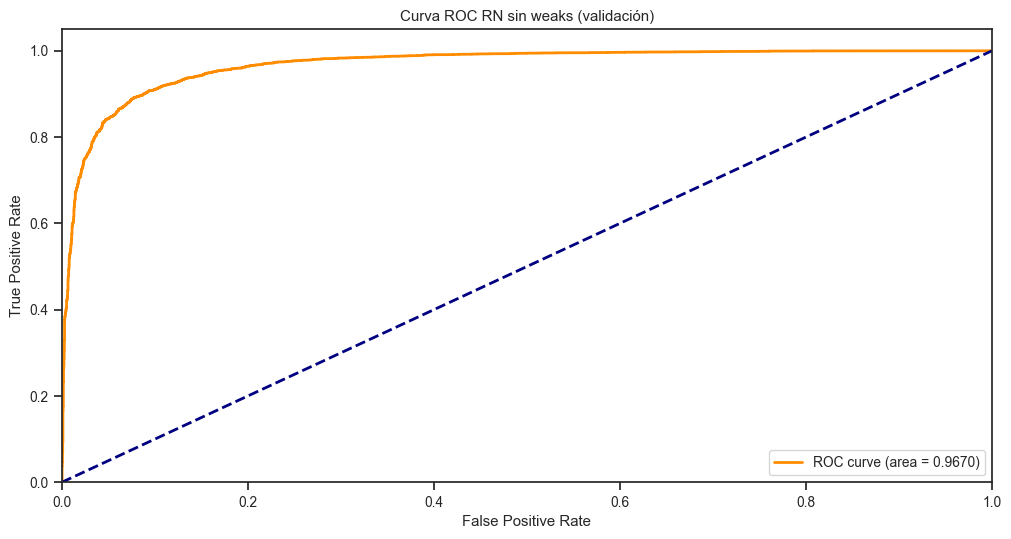

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, prediccion)
titulo = "Curva ROC RN sin weaks (validación)"
plot_roc(fpr, tpr, thresholds, titulo)

## Evaluo la red (con test)

In [ ]:
prediccion = modelo.predict(embeddings_test)

308/308 [==============================] - 0s 385us/step


In [ ]:
round(roc_auc_score(tw_ingles_portuges_target_test, prediccion, average='micro'), 4)

0.9615

### Grafico la cruva roc 

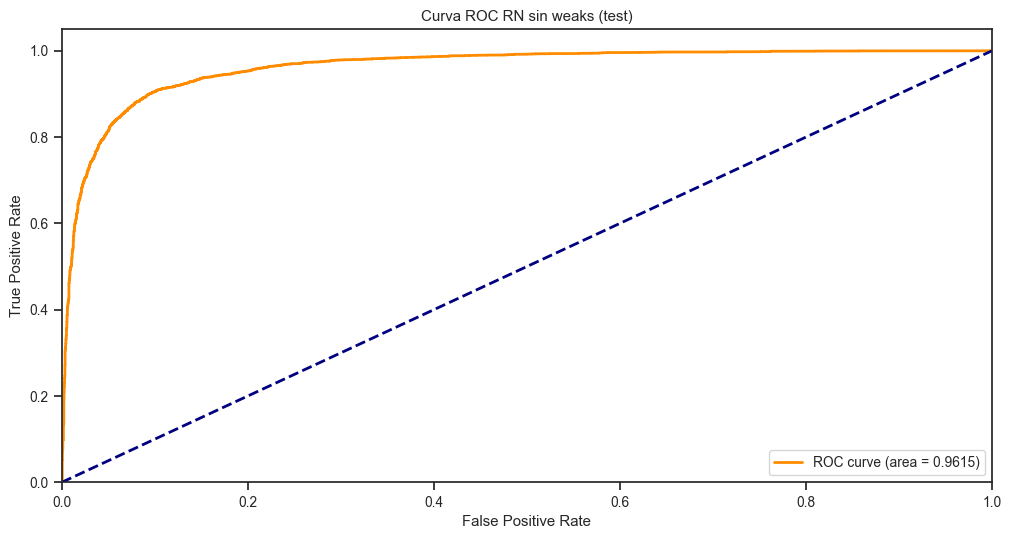

In [ ]:
fpr, tpr, thresholds = roc_curve(tw_ingles_portuges_target_test, prediccion)
titulo = "Curva ROC RN sin weaks (test)"
plot_roc(fpr, tpr, thresholds, titulo)

# LASER con weaks

## Obtengo los embeddings de weak train

In [ ]:
weak_tain = tw_ingles_portuges_weak_train_df['Tweet-Content'].fillna("Without data")

lista_weak_tweets_train = weak_tain.to_list()
lista_weak_idiomas_train = tw_ingles_portuges_weak_train_df.Lang

laser = Laser()
embeddings_weak_train = laser.embed_sentences(lista_weak_tweets_train, lang=lista_weak_idiomas_train)

## Entreno la red

In [ ]:
modelo = Sequential()
modelo.add(Dense(16, input_shape=(1024,), activation='tanh'))
modelo.add(Dense(8, activation='tanh'))
modelo.add(Dense(4, activation='tanh'))
modelo.add(Dense(1, activation="sigmoid"))

In [ ]:
opt = keras.optimizers.Adam(lr=0.0001)
modelo.compile(loss='binary_crossentropy', optimizer=opt, metrics=['AUC'])
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                16400     
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 16,577
Trainable params: 16,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historia = modelo.fit(
    embeddings_weak_train, tw_ingles_portuges_weak_train_target_df.values, epochs=60, batch_size=256, validation_split=0.1
)

Epoch 1/60
119/119 [==============================] - 1s 2ms/step - loss: 0.6881 - auc: 0.6584 - val_loss: 0.6810 - val_auc: 0.7560
Epoch 2/60
119/119 [==============================] - 0s 1ms/step - loss: 0.6722 - auc: 0.7962 - val_loss: 0.6607 - val_auc: 0.8223
Epoch 3/60
119/119 [==============================] - 0s 1ms/step - loss: 0.6459 - auc: 0.8273 - val_loss: 0.6295 - val_auc: 0.8544
Epoch 4/60
119/119 [==============================] - 0s 1ms/step - loss: 0.6111 - auc: 0.8362 - val_loss: 0.5899 - val_auc: 0.8635
Epoch 5/60
119/119 [==============================] - 0s 1ms/step - loss: 0.5747 - auc: 0.8440 - val_loss: 0.5518 - val_auc: 0.8779
Epoch 6/60
119/119 [==============================] - 0s 1ms/step - loss: 0.5427 - auc: 0.8504 - val_loss: 0.5160 - val_auc: 0.8866
Epoch 7/60
119/119 [==============================] - 0s 1ms/step - loss: 0.5167 - auc: 0.8571 - val_loss: 0.4863 - val_auc: 0.8954
Epoch 8/60
119/119 [==============================] - 0s 1ms/step - loss: 0.

## Evaluo la red (con validación)

In [ ]:
prediccion = modelo.predict(embeddings_val)

286/286 [==============================] - 0s 379us/step


In [ ]:
round(roc_auc_score(y_val, prediccion, average='micro'), 4)

0.9579

### Grafico la cruva roc 

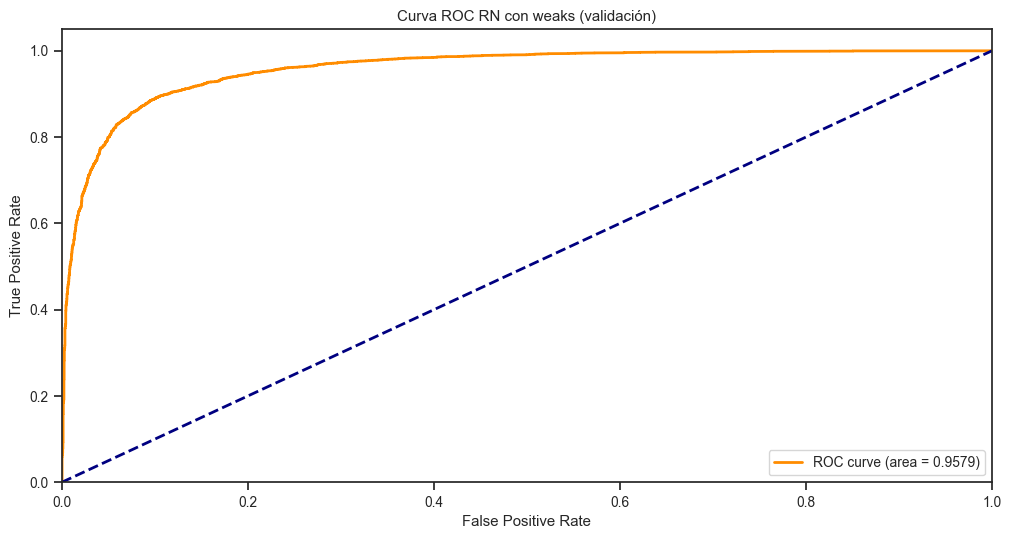

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, prediccion)
titulo = "Curva ROC RN con weaks (validación)"
plot_roc(fpr, tpr, thresholds, titulo)

## Evaluo la red (con test)

In [ ]:
prediccion = modelo.predict(embeddings_test)

308/308 [==============================] - 0s 385us/step


In [ ]:
round(roc_auc_score(tw_ingles_portuges_target_test, prediccion, average='micro'), 4)

0.9505

### Grafico la cruva roc 

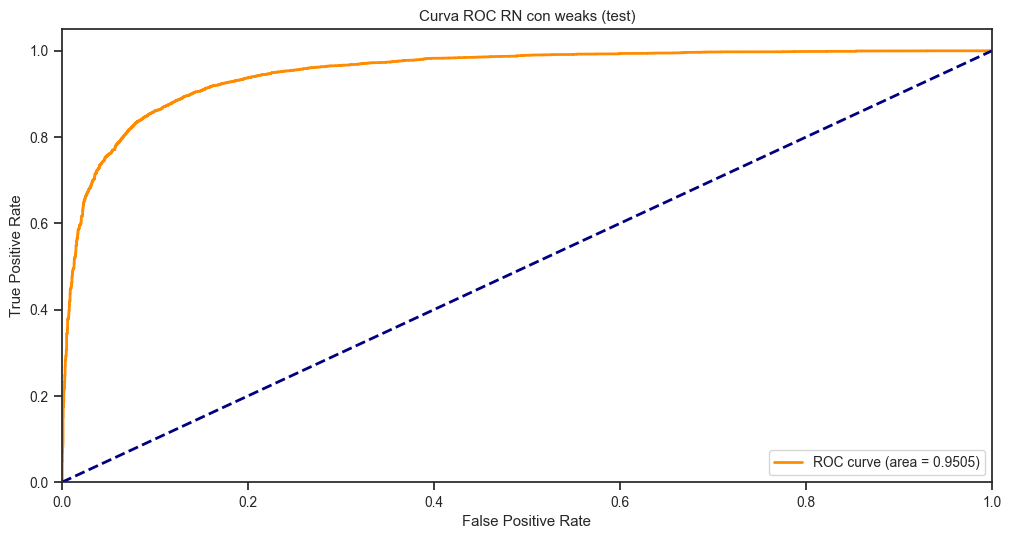

In [ ]:
fpr, tpr, thresholds = roc_curve(tw_ingles_portuges_target_test, prediccion)
titulo = "Curva ROC RN con weaks (test)"
plot_roc(fpr, tpr, thresholds, titulo)

# ¿Cómo conviene usar los débilmente clasificados?

Para este modelo, es mejor no usar los débilmente clasificados